# 3.6 손글씨 숫자 인식

In [1]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## 3.6.1 MNIST 데이터셋

* MNIST 데이터셋은 0부터 9까지 숫자 이미지로 구성된다.
* 훈련 이미지가 60,000장, 테스트 이미지가 10,000장 준비되어있다.
* 훈련 이미지들을 사용하여 모델을 학습하고, 학습한 모델로 테스트 이미지를 얼마나 정확하게 분류하는지 평가한다.
* MNIST의 이미지 데이터는 (28, 28) 크기의 회색조 이미지 이며, 각 픽셀은 0부터 255까지의 값을 취한다.
* 각 이미지에는 그 이미지가 의미하는 실제 숫자가 레이블로 붙어있다.

In [2]:
from mnist import load_mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = load_mnist(flatten=True, normalize=False)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


* load_mnist 함수는 읽은 MNIST 데이터를 (훈련 이미지, 훈련 레이블), (테스트 이미지, 테스트 레이블) 형식으로 분류한다.
* 인수로는 normalize, flatten, ont_hot_label 세 가지를 설정할 수 있다. 세 인수 모두 bool 값이다.
* 첫번째 인수는 normalize는 입력 이미지의 픽셀값을 0.0 ~ 1.0 사이의 값으로 정규화할지를 정한다.
* 두번째 인수는 flatten은 입력 이미지를 1차원 배열로 만들지 결정한다.
* 세번째 인수인 one_hot_label은 레이블을 원-핫 인코딩 형태로 저장할지를 결정한다.
* 원-핫 인코딩이란, 정답에 해당하는 원소만 1이고 나머지는 0인 배열을 말한다.

5
(784,)
(28, 28)


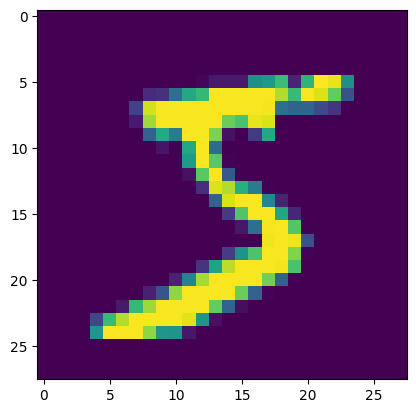

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

img = train_images[0]
label = train_labels[0]
print(label)

print(img.shape)
img = img.reshape(28, 28)
print(img.shape)

plt.imshow(img)
plt.show()

* 여기서 주의사항으로, "Flatten=True"로 설정해 읽어들인 이미지는 1차원 넘파이 배열로 저장되어있다.(784, )
* 그래서 이미지를 표시할 때는 원래 형상인 (28, 28)크기로 다시 변형 해야 한다.
* reshape() 메서드에 원하는 형상을 인수로 지정하면 넘파이 배열의 형상을 바꿀 수 있다.

# 3.6.2 신경망의 추론 처리

* 이 신경망은 입력층 뉴런을 784개(이미지의 크기가 28$*$28 형태), 출력층 뉴런을 10개(숫자 0 ~ 9)로 구성한다.
* 한편, 은닉층은 총 두개로, 첫번째 은닉층에는 50개의 뉴런을, 두번째 은닉층에는 100개의 뉴런을 배치할 것이다.(50과 100은 임의의 값)

In [4]:
import pickle

def get_data():
    (train_images, train_labels), (test_images, test_labels) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    
    return test_images, test_labels

def init_network():
    with open('sample_weight.pkl', 'rb') as f:
        network =  pickle.load(f)
        
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

In [5]:
test_images, test_labels = get_data()
network = init_network()

acc_cnt = 0

for i in range(len(test_images)):
    y = predict(network, test_images[i])
    p = np.argmax(y)
    if p == test_labels[i]:
        acc_cnt += 1

print('Accuracy :' + str(float(acc_cnt) / len(test_images)))

Accuracy :0.9352


## 3.6.3 배치 처리

* 구현 진도를 더 나가기 전에, 입력 데이터와 가중치 매개변수의 '형상'에 대해 주의해서 조금 전의 구현을 다시 살펴보자.
* 우선 앞서 구현한 신경망 각 층의 가중치 형상을 출력해보자.

In [6]:
test_images, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

test_images.shape, test_images[0].shape, W1.shape, W2.shape, W3.shape

((10000, 784), (784,), (784, 50), (50, 100), (100, 10))

* 이 결과에서 다차원 배열에 대응하는 차원의 원소 수가 일치함을 확인할 수 있다.
* 그리고 최종 결과로는 원소가 10개인 1차원 배열 y가 출력되는 점도 확인하자.

<img src="https://mblogthumb-phinf.pstatic.net/MjAxODA2MTNfMTY4/MDAxNTI4ODYwNjA1OTkz.6llrm8p-pIf4pQDgo3E5GnNXm1Y7Q8IvSqJMmtoLJh0g.WZQP-xfgTyB5NEKW-3dMR2ORwOo09qRKtRsmcx3-0bIg.PNG.ssdyka/fig_3-26.png?type=w2" align="left">

* 위 그림을 보면, 전체적으로 원소 784개로 구성된 1차원 배열(원래는 28$*$28인 2차원 배열)이 입력되어 마지막에는 원소가 10개인 1차원 배열이 출력되는 흐름이다. 이는 이미지 데이터를 1장만 입력 했을 때 처리 흐름이다

<img src="https://mblogthumb-phinf.pstatic.net/MjAxODA2MTNfMTE4/MDAxNTI4ODYwNjA2NDMx.xczzwbxvurbAu8s1JglV3DzTc-sF3gB73-keh2NiCdQg.vQPCsuiRRbJwLjCCk02IDUEITsummwhb6Lbdl1x66oEg.PNG.ssdyka/fig_3-27.png?type=w2" align="left">

* 위의 그림과 같이 입력 데이터의 형상은 100$*$784, 출력 데이터의 형상은 100$*$10이 된다. 이는 100장 분량 입력 데이터의 결과가 한번에 출력됨을 나타낸다.
* 가령 x[0]과 y[0]에는 0번째 이미지와 추론 결과가, x[1]과 y[1]에는 첫번째의 이미지와 그 추론 결과가 저장되는 식이다.
* 이처럼 하나로 묶은 입력 데이터를 <span style="background-color:yellow">배치</span>라 한다.
* 이미지가 지폐처럼 다발로 묶여있다고 생각하면 된다.

* 이제 배치처리를 구현해보자

In [7]:
test_images, test_labels = get_data()
network = init_network()

batch_size = 10
acc_cnt = 0

for i in range(0, len(test_images), batch_size):
    test_images_batch = test_images[i : i+batch_size]
    test_labels_batch = predict(network, test_images_batch)
    p = np.argmax(test_labels_batch, axis=1)
    acc_cnt += np.sum(p == test_labels[i : i+batch_size])

print("Accuracy :" + str(float(acc_cnt) / len(test_images)))

Accuracy :0.9352


* range(start, end, step) 처럼 인수를 3개 지정하면, start에서 end-1까지 step간격으로 증가하는 정수를 반환하는 반복자를 돌려준다
* argmax()는 최댓값의 인덱스를 가져온다. 다만 여기에서는 axis=1이라는 인수를 추가하였다. 이는 100$*$10의 배열 중 첫번째 차원을 구성하는 각 원소에서(첫번째 차원을 축으로) 최댓값의 인덱스를 찾도록 한 것이다. 다음 예를 살펴보자.

In [8]:
x = np.array([[0.7, 0.5, 0.3], [1.6, 3.8, 0.7], [2.1, 3.4, 2.1], [6.1, 1.3, 4.2]])

y = np.argmax(x, axis=1)
print(y)

[0 1 1 0]


* 마지막으로 배치 단위로 분류한 결과를 실제 답과 비교한다. 이를 위해 '==' 연산자를 사용해 넘파이 배열끼리 비교하여 True/False로 구성된 bool배열을 만들고, 이 결과 배열에서 True가 몇 개인지 센다.

In [9]:
y = np.array([0, 1, 1, 0])
t = np.array([0, 1, 0, 0])

print(y==t)
print(np.sum(y==t))

[ True  True False  True]
3
